In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys

!git clone https://github.com/wjteng/LBC-IoT-Key-Recovery.git

sys.path.insert(0,'/content/LBC-IoT-Key-Recovery')

import numpy as np
from os import urandom
import lbciot as cipher
import pandas as pd
import train_nets as tn

rounds = 6;
epoch = 40;
diff1 = 0x2000;
diff2 = 0x0000;

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);

model, h =tn.train_distinguisher(epoch,(diff1,diff2),num_rounds=rounds,depth=10);

model.save('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

Mounted at /content/gdrive/
Cloning into 'LBC-IoT-Key-Recovery'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 130 (delta 71), reused 91 (delta 46), pack-reused 0
Receiving objects: 100% (130/130), 279.14 KiB | 27.91 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Epoch 1/40
200/200 [==============================] - 37s 110ms/step - loss: 0.2438 - acc: 0.5680 - val_loss: 0.4036 - val_acc: 0.5070 - lr: 0.0020
Epoch 2/40
200/200 [==============================] - 21s 107ms/step - loss: 0.1359 - acc: 0.8197 - val_loss: 0.3092 - val_acc: 0.5906 - lr: 0.0018
Epoch 3/40
200/200 [==============================] - 22s 108ms/step - loss: 0.0658 - acc: 0.9295 - val_loss: 0.0934 - val_acc: 0.8821 - lr: 0.0016
Epoch 4/40
200/200 [==============================] - 22s 109ms/step - loss: 0.0393 - acc: 0.9642 - val_loss: 0.0408 - val_acc: 0.9629 - lr: 0.0014
Epoch 5/40
200/200 [=============

0
10000
20000
30000
40000
50000
60000


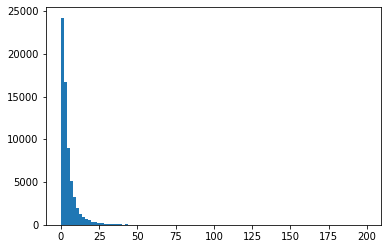

found max:12610
correct key:12610
[[12610   199]
 [28994   169]
 [13634   155]
 [12738   142]
 [ 4418   128]
 [30018   128]
 [45378   124]
 [29122   117]
 [12611   113]
 [20802   113]
 [28995   113]
 [13762   111]
 [12354   110]
 [ 8514   109]
 [12614   105]
 [12624   105]
 [61762   102]
 [45506   101]
 [12626   100]
 [ 5442    96]
 [28738    94]
 [24898    93]
 [13378    90]
 [12619    89]
 [12618    88]
 [29003    88]
 [46402    88]
 [13638    87]
 [30019    87]
 [12608    86]]
found max:12752
correct key:12610
[[12752    86]
 [13635    86]
 [30146    86]
 [28998    85]
 [12546    84]
 [12754    84]
 [29008    84]
 [45376    84]
 [13648    82]
 [29010    82]]


In [2]:

n = 200; #number of plaintext pairs

rounds = 6;
epoch = 40;
diff1 = 0x2000;
diff2 = 0x0000;

key = np.frombuffer(urandom(10),dtype=np.uint16).reshape(5,-1);
keys = np.frombuffer(urandom(10*n),dtype=np.uint16).reshape(5,-1)*0+1 ;


for i in range(0,n):
  for j in range(0,5):
    keys[j][i]=key[j];


pt0l = np.frombuffer(urandom(2*n),dtype=np.uint16);
pt0r = np.frombuffer(urandom(2*n),dtype=np.uint16);

p0l = np.copy(pt0l); 
p0r = np.copy(pt0r);

p1l = p0l^diff1;
p1r = p0r^diff2;

ks = cipher.expand_key(keys, rounds + 1);

c0l,c0r = cipher.encrypt((p0l,p0r),ks);
c1l,c1r = cipher.encrypt((p1l,p1r),ks);



from tensorflow import keras

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);
model = keras.models.load_model('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

allkeys = ks[rounds]*0;

count = np.zeros(2**16,dtype=int);

for i in range(0,2**16):
  if i%10000==0:
    print(i);
  c0l_dec1,c0r_dec1 = cipher.dec_one_round((c0l,c0r),allkeys);
  c1l_dec1,c1r_dec1 = cipher.dec_one_round((c1l,c1r),allkeys);
  X = cipher.convert_to_binary([c0l_dec1,c0r_dec1,c1l_dec1,c1r_dec1]);
  Z = model.predict(X,batch_size=10000);
  count[allkeys[0]] =  np.sum(Z>0.5);
  allkeys = allkeys + 1;

df = pd.DataFrame(count);
df.to_csv('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+'count_'+str(diff1)+'_'+str(diff2)+'.csv');

import matplotlib.pyplot as plt

plt.hist(count, bins=100)
plt.savefig('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name+'_counthist.png')
plt.show()


count[np.argmax(count)]
print('found max:'+str(np.argmax(count)))
print('correct key:'+str(ks[rounds][0]));
count[41855]
sorted_count = -np.sort(-count);
temp = count;
top = 30;
rank = np.zeros((top,2),dtype=int);
for i in range(0,top):
  max_index = np.argmax(temp);
  rank[i][0] = max_index;
  rank[i][1] = temp[max_index];
  temp[max_index]=-1;

print(rank);



